# Notebook 1: Analyzing phenotypic nonlinearity across species

## Initiating workspace and loading data

<font size="3"> Set working directory

In [1]:
library(here)
here() # Should be set to the root of the repository
setwd(here())

here() starts at /Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes



[1] "/Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes"

<font size="3"> Source functions

In [3]:
suppressPackageStartupMessages(source('01_code/R/nonlinear_phenotype_utils.R'))

<font size="3"> Download data from Zenodo

In [8]:
#Create directory to store data in
system('mkdir data')

#Download data
download_zenodo(doi = "10.5281/zenodo.8298808", 
                path = 'data/',
                quiet = TRUE)

<font size="3"> Load pre-cleaned data (details on how data were cleaned are available in the pub)

In [16]:
# Yeast
yeast <- readRDS("02_output/empirical-phenotypes/yeast_cleaned_phenos.RDS")

# C. elegans
nematode <- readRDS("02_output/empirical-phenotypes/nematode_cleaned_phenos.RDS")

# Arabadopsis
ara <- readRDS("02_output/empirical-phenotypes/arapheno_cleaned_phenos.RDS")

# DGRP
dgrp <- readRDS("02_output/empirical-phenotypes/dgrp_cleaned_phenos.RDS")

# JAX
jax <- readRDS("02_output/empirical-phenotypes/jax_cleaned_phenos.RDS")

# AIL
ail <- readRDS("02_output/empirical-phenotypes/ail_cleaned_phenos.RDS")

# QTL archive
qtlarch <- readRDS("02_output/empirical-phenotypes/qtlarchive_cleaned_phenos.RDS")

# Compile into a single list
phenos <- list(
  yeast,
  nematode,
  ara[[3]],
  dgrp,
  jax,
  ail
)
names(phenos) <- c("yeast", "nematode", "ara", "dgrp", "jax", "ail")

## Calculate and compare nonlinearity

<font size="3"> Calculate nonlinearity distributions for each species. Here, we use permutation tests (random 25% of the data at time) to generate this distruibution for each species in order to infer within-species variance. 

In [4]:
#Generate empty list to save results into
nonlinear_permutations <- list()

# Run permutation test for each species/phenotypic data set
for (i in 1:length(phenos)) {
  print(paste(i, 'out of', length(phenos)))
    
    # Given the large n for the yeast dataset, subsample data
  if (i == 1) {
    nonlinear_permutations[[names(phenos)[i]]] <- nonlinear.permutation(
        phenos[[i]][sample(1:nrow(phenos[[i]]), 1000), ],                                                      
        data_proportion = 0.25, 
        permutation_number = 100, 
        counter = TRUE)

    )
  } else {
    nonlinear_permutations[[names(phenos)[i]]] <- nonlinear.permutation(
      phenos[[i]],
      data_proportion = 0.25,
      permutation_number = 100,
      counter = TRUE
    )
  }
}

# Calculate random distribution
dat <- list()
for (i in 1:20) {
  dat[[i]] <- sample(1:1000, 600, replace = TRUE)
}
dat <- do.call(cbind, dat)

# Calculate nonlinearity of random data
random <- nonlinear.permutation(
  dat,
  data_proportion = 0.25,
  permutation_number = 100,
  counter = TRUE
)

# Add random data to the results list
nonlinear_permutations$random <- random

# Add random data to phenotypes
phenos$random <- dat

[1] "1 out of 6"
  |..................................................| 100%[1] "2 out of 6"
  |..................................................| 100%[1] "3 out of 6"
  |..................................................| 100%[1] "4 out of 6"
  |..................................................| 100%[1] "5 out of 6"
  |..................................................| 100%[1] "6 out of 6"
  |..................................................| 100%

<font size="3"> Save output

In [7]:
saveRDS(
  nonlinear_permutations,
  '02_output/empirical-phenotypes/empirical_datasets_permuted_nonlinearity.RDS'
)

<font size="3"> Compare nonlinearity, variance, and correlation

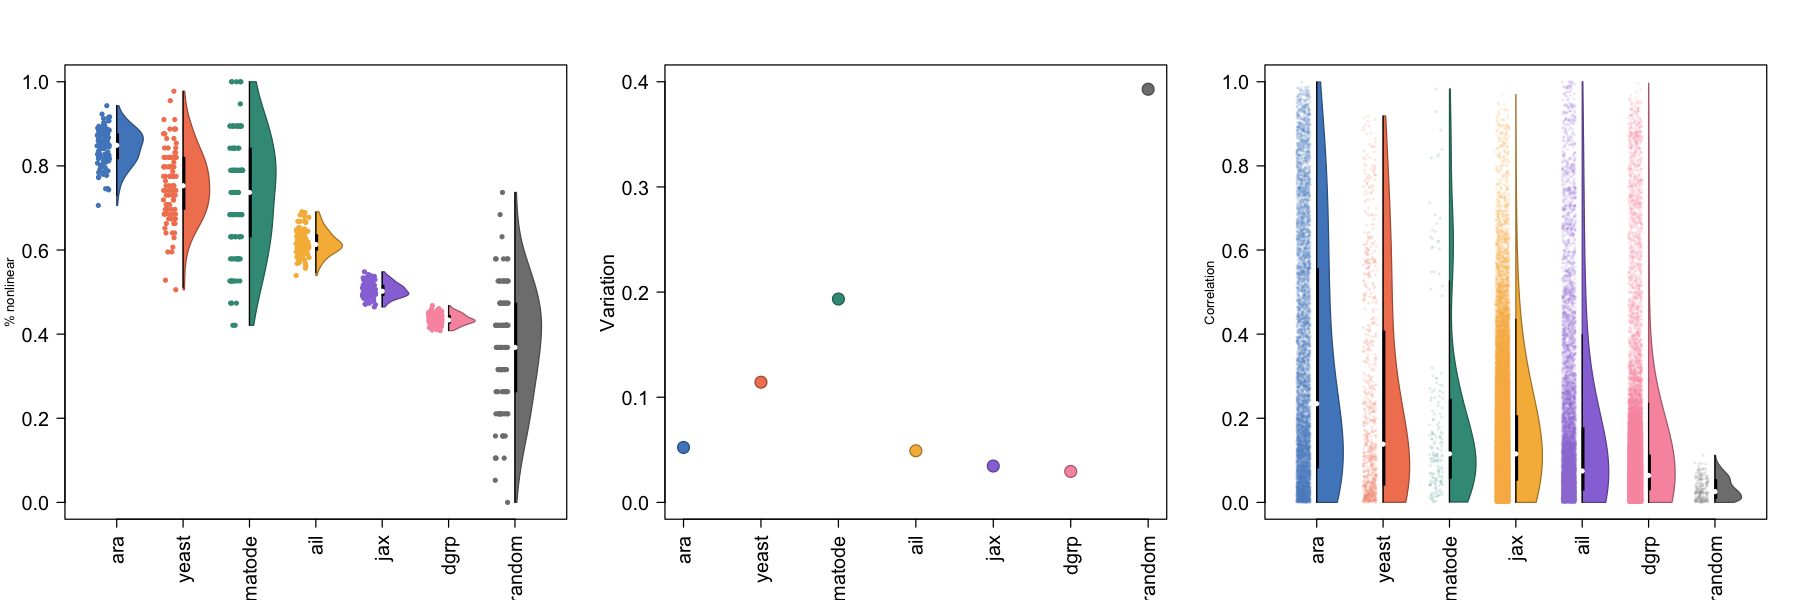

In [23]:
options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow = c(1, 3))

# Load nonlinearity results
nonlinear_permutations <- readRDS('02_output/empirical-phenotypes/empirical_datasets_permuted_nonlinearity.RDS')

# Set colors 
cols <- c(arcadia.pal(n = 6, name = "Accent"), "gray50")
names(cols) <- names(nonlinear_permutations)

# Distributions
vioplot::vioplot(nonlinear_permutations[[1]],
  nonlinear_permutations[[2]],
  nonlinear_permutations[[3]],
  nonlinear_permutations[[4]],
  nonlinear_permutations[[5]],
  nonlinear_permutations[[6]],
  nonlinear_permutations[[7]],
  col = cols,
  side = "right",
  border = darken_color(cols),
  ylab = "% nonlinear",
  xlab = "",
  las = 2,
  names = names(nonlinear_permutations),
  cex.axis = 1.5,
  cex.lab = 1.5
)

stripchart(nonlinear_permutations,
  col = cols,
  at = seq(0.8, (length(nonlinear_permutations) - 1) + 0.8, 1),
  jitter = 0.1,
  method = "jitter",
  vertical = TRUE,
  cex = 1,
  pch = 20,
  add = TRUE
)

# Variance
plot(unlist(lapply(nonlinear_permutations, function(x) sd(x) / mean(x))),
  pch = 21,
  ylim = c(0, 0.4),
  xlab = "",
  bg = cols,
  col = darken_color(cols),
  cex = 2,
  las = 2,
  xaxt = "n",
  ylab = "Variation",
  cex.lab = 1.5,
  cex.axis = 1.5
)
axis(1, 1:7, labels = names(nonlinear_permutations), las = 2, cex.axis = 1.5)

# Calculate trait correlations per species
trait_correlations <- list()
for (i in 1:length(phenos)) {
  corr <- cor(phenos[[i]])
  trait_correlations[[names(phenos)[i]]] <- abs(unlist(as.data.frame(corr[lower.tri(corr)])))
}

# Correlation
trait_correlations <- trait_correlations[order(unlist(lapply(trait_correlations, function(x) median(x))), 
                                                             decreasing = TRUE)]
vioplot::vioplot(trait_correlations[[1]],
  trait_correlations[[2]],
  trait_correlations[[3]],
  trait_correlations[[4]],
  trait_correlations[[5]],
  trait_correlations[[6]],
  trait_correlations[[7]],
  col = cols,
  side = "right",
  border = darken_color(cols),
  ylab = "Correlation",
  xlab = "",
  las = 2,
  names = names(trait_correlations),
  cex.axis = 1.5,
  cex.lab = 1.5
)

stripchart(trait_correlations,
  col = alpha(cols, 0.1),
  at = seq(0.8, (length(trait_correlations) - 1) + 0.8, 1),
  jitter = 0.1,
  method = "jitter",
  vertical = TRUE,
  cex = 0.5,
  pch = 20,
  add = TRUE
)